<br>
<h1><center><font size="6">Final Project: Non-negative Tweet Detection</font></center></h1>

<center><font size="4">Chenxi (Susie) Tao, MSBA</font></center>
<center><font size="4">Dec 19th, 2019</font></center>

**<font size="5">1 Preparation</font>**

<font size="3">The goal of final project is using the **'complaint1700'** and **'non-complaint1700'** file to train a robust classification model, which can be used afterwards to test if a new tweet is negative and help the company to separate the non-negative tweets.
<br>
<br>To begin with, I firstly imported basic packages to set the environment and saved all the necessary data in a certain working directory.

**<font size="4">1.1 Import Packages</font>**

In [634]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from IPython.display import Image

# Packages for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score

# Packages for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [630]:
# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

**<font size="4">1.2 Load Data</font>**

<font size="3">It should be noted that the tagged tweets that I need to detect was retrieved solely from http://r.twittersensor.com. 
<br>Instead of Python, I used R for that purpose, and my tag is **'xW\v1i81&Wef'**.

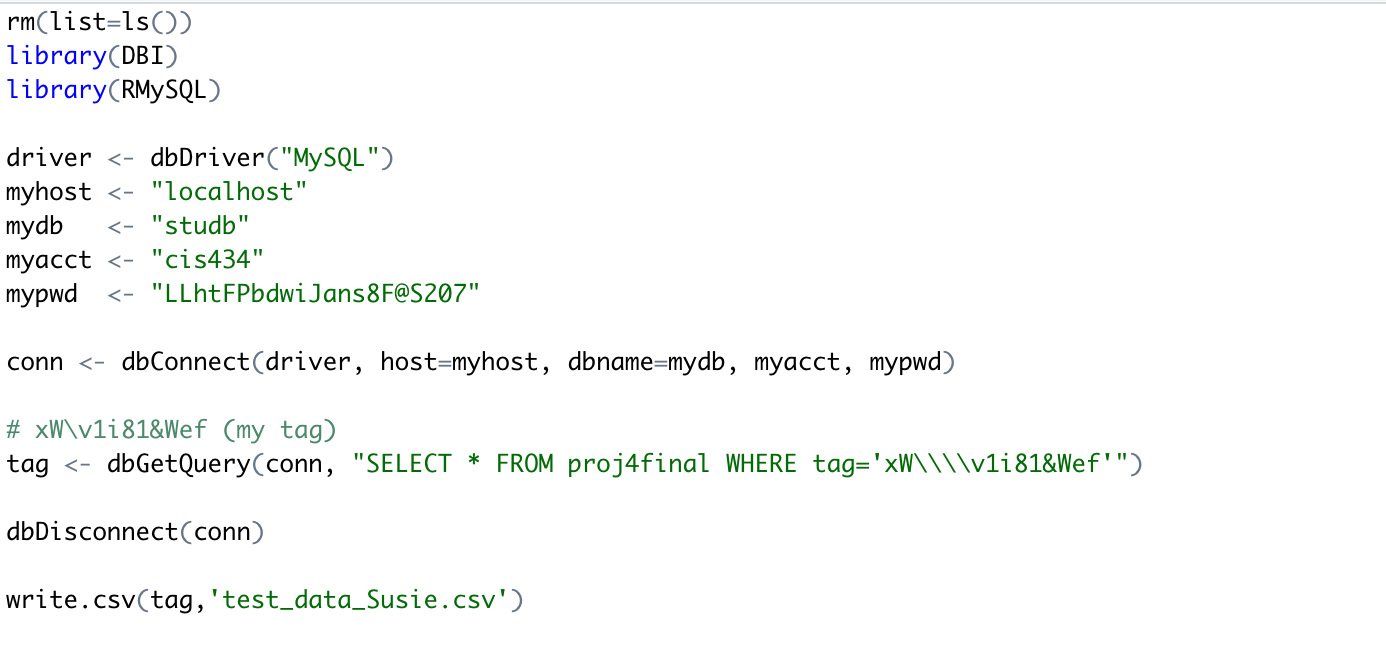

In [639]:
Image(filename='tag.png',width=700, height=350)

<font size="3"> After that, I listed all the files in the current working directory. What I need is **'complaint1700'**, **'noncomplaint1700'** and **'test_data_Susie'**.

In [633]:
!ls

Deep Learning with Python.pdf
Instructions (tagged).pdf
LoughranMcDonald_SentimentWordLists_2018.xlsx
chenxi_tao(156).xlsx
chenxi_tao(280).xlsx
chenxi_tao.csv
chenxi_tao.ipynb
chenxi_tao.xlsx
complaint1700.csv
manual.csv
non_neg_tweet.xlsx
noncomplaint1700.csv
output_file.csv
tag.R
test_data_Neil.csv
test_data_Susie.csv
~$non_neg_tweet.xlsx


In [640]:
# Read csv files
with open('complaint1700.csv') as f1:
    neg_data = pd.read_csv(f1)
with open('noncomplaint1700.csv') as f2:
    pos_data = pd.read_csv(f2)
# Convert the categorical variable to binary variable
neg_data['target'] = 0
pos_data['target'] = 1
# Concat the two dataset to build a training set # Drop insignificant columns
training_data = pd.concat([neg_data,pos_data],ignore_index=True)[['tweet','target']]

<font size="3"> That's what training data looks like.

In [642]:
training_data.head()

,tweet,target
0,"@united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?",0
1,"@united kinda feel like the $6.99 you charge for in flight Wi-Fi is ridiculous. AND it sucks, slow, or doesn't work. #anythingtomakeabuck",0
2,"Livid in Vegas, delayed, again&amp; again&amp;again, @SouthwestAir decided to cancel a flight and combine two, then waited on crew, now pilots.",0
3,@united the most annoying man on earth is on my flight. what can you do to help me?,0
4,"@united The last 2 weeks I've flown wit u, you have given me 4 reasons to convince me it was a bad decision. Time 2 go back 2 @SouthwestAir",0


In [641]:
with open(folder+'test_data_Susie.csv') as f:
    real_data = pd.read_csv(f)

$\qquad$

**<font size="5">2 Data Pre-processing</font>**

In [374]:
# Stop words
stop_words = set(stopwords.words('english'))
# Some words which might indicate a certain sentiment are kept via a whitelist
whitelist = ["n't", "not", "no"] 
# Lemmatize
wordnet_lemmatizer = WordNetLemmatizer()

<font size="3">I defined to function to automatically deal with raw text data.

In [375]:
def normalizer(tweet):
    # remove punctuation mark
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    # tokenize
    tokens = nltk.word_tokenize(only_letters) 
    # convert everything to lowercase
    lower_case = [l.lower() for l in tokens] 
    # remove words in stop_words and keep words in whitelist
    filtered_result = list(filter(lambda l: l not in stop_words or l in whitelist, lower_case)) 
    # stem
    stems1 = [porter.stem(t) for t in filtered_result]
    stems2 = [lancaster.stem(t) for t in stems1]
    # lemmatize
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in stems2]
    # join the words together
    normalized_tweet = " ".join(lemmas) 
    return normalized_tweet

<font size="3"> That's what it looks like.

In [376]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
training_data['normalized_tweet'] = training_data.tweet.apply(normalizer)
training_data[['tweet','normalized_tweet']].head()

,tweet,normalized_tweet
0,"@united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?",unit issu yesterday rebook hour suppo fli log amp check help
1,"@united kinda feel like the $6.99 you charge for in flight Wi-Fi is ridiculous. AND it sucks, slow, or doesn't work. #anythingtomakeabuck",unit kind feel lik charg flight wi fi ridic suck slow work anythingtomakeabuck
2,"Livid in Vegas, delayed, again&amp; again&amp;again, @SouthwestAir decided to cancel a flight and combine two, then waited on crew, now pilots.",livid veg delay amp amp southwestair decid cancel flight combin two wait crew pilot
3,@united the most annoying man on earth is on my flight. what can you do to help me?,unit annoy man ear flight help
4,"@united The last 2 weeks I've flown wit u, you have given me 4 reasons to convince me it was a bad decision. Time 2 go back 2 @SouthwestAir",unit last week flown wit u giv reason convint bad dec tim go back southwestair


<font size="3">I converted a collection of texts to a matrix of token counts, which can be regarded as **'features'**.

In [381]:
CV = CountVectorizer(analyzer='word')
features = CV.fit_transform(training_data.normalized_tweet)
features_nd = features.toarray() 

$\qquad$

**<font size="5">3 Cross Validation</font>**

**<font size="4">3.1 Train-test Split</font>**

<font size="3"> I used **'features_nd'** as independent variable and **'training_data.target'** as dependent variable; **90%** of the dataset was used for training, and the other **10%** for validation.

In [394]:
X_train, X_test, y_train, y_test = train_test_split(features_nd, training_data.target, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 3060
# Test data samples: 340


**<font size="4">3.2 Select Optimal Model</font>** 

<font size="3"> I defined two new functions, one for choosing the **optimal hyperparameter** and the other for showing the **AUC & Accuracy**.

In [395]:
def gridSearchCV(model, params):
    """
    @param    model: sklearn estimator
    @param    params (dict): Dictionary of possible parameters
    
    @return   cv_results (DataFrame)
    """
    model_cv = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=5)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]
    
    return cv_results

def evaluate(model, plotROC=False):
    """
    1. Print AUC and accuracy on the test set
    2. Plot ROC
    """
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    # Find optimal threshold
    rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
    rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
    optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]
    
    # Get accuracy over the test set
    y_pred = np.where(preds >= optimalThreshold, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    if plotROC:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

$\qquad$**<font size="4">3.2.1 Randon Forest</font>**

In [410]:
params = {'n_estimators': [50, 200,500]}
rfc = RandomForestClassifier(random_state=1)
print(gridSearchCV(rfc, params))

                  params  mean_test_score
0  {'n_estimators': 50}   0.814603       
1  {'n_estimators': 200}  0.823310       
2  {'n_estimators': 500}  0.824779       


AUC: 0.8304
Accuracy: 76.18%


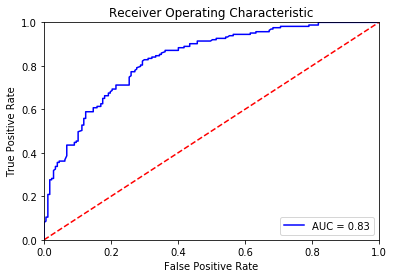

In [411]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=1)
evaluate(rfc, plotROC=True)

$\qquad$**<font size="4">3.2.2 Logistic Regression</font>**

In [427]:
params = {'C': [0.01, 0.1,0.5,1]}
logit = LogisticRegression()
print(gridSearchCV(logit, params))

        params  mean_test_score
0  {'C': 0.01}  0.783632       
1  {'C': 0.1}   0.817749       
2  {'C': 0.5}   0.820472       
3  {'C': 1}     0.817267       


AUC: 0.8517
Accuracy: 77.35%


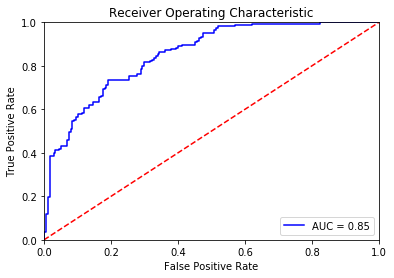

In [426]:
logit = LogisticRegression(C=0.5)
evaluate(logit, plotROC=True)

$\qquad$**<font size="4">3.2.3 Support Vector Machine</font>**

In [408]:
params = {'C': [0.1,1]}
svc = SVC(gamma='auto',kernel='rbf',random_state=1)
print(gridSearchCV(svc, params))

       params  mean_test_score
0  {'C': 0.1}  0.748026       
1  {'C': 1}    0.748009       


In [523]:
from sklearn.svm import SVC
params = {'C': [0.1]}
svc = SVC(gamma='auto', random_state=1)
print(gridSearchCV(svc, params))

       params  mean_test_score
0  {'C': 0.1}  0.748026       


$\qquad$**<font size="4">3.2.4 MultimonialNB</font>**

In [647]:
params = {'alpha':[0.1,0.5,1,1.5]}
mnb = MultinomialNB()
print(gridSearchCV(mnb, params))

           params  mean_test_score
0  {'alpha': 0.1}  0.796417       
1  {'alpha': 0.5}  0.818031       
2  {'alpha': 1}    0.823414       
3  {'alpha': 1.5}  0.825658       


AUC: 0.8503
Accuracy: 77.06%


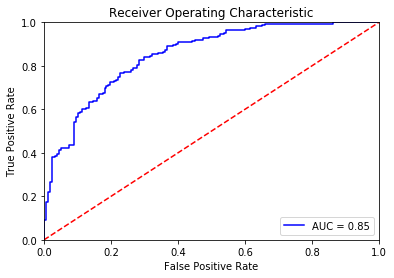

In [646]:
mnb = MultinomialNB(alpha=1.5)
evaluate(mnb, plotROC=True)

<font size="3"> Among four models, **Logistic Model** has the highest AUC of **0.8517** and the highest accuracy of **77.35%**.

$\qquad$

**<font size="5">4 Non-negative Tweet Detection</font>**

<font size="3"> That's the tagged dataset looks like.

In [525]:
real_data.head()

,Unnamed: 0,id,tid_not_to_be_used,airline,tag,tweet
0,1,88,5.062858e+17,American,xW\v1i81&Wef,WiFi on board @AmericanAir flight - but flight delayed. :(
1,2,96,5.062970e+17,American,xW\v1i81&Wef,@AmericanAir Flight canceled after sitting on the plane waiting for 4 hours!! Unbelievably terrible experience! @TravelGov
2,3,155,5.064352e+17,American,xW\v1i81&Wef,@michael_seeless @hotaviationnews @AmericanAir @Jaqwizzy The crash at Mt. Erebus was not the fault of the DC10.
3,4,217,5.064623e+17,VirginAmerica,xW\v1i81&Wef,@IIJERiiCHOII @VirginAmerica The fact that these virgins (so to speak :)) can go to those lengths just to get a laugh... Pathetic.
4,5,296,5.064969e+17,JetBlue,xW\v1i81&Wef,"@united likes to lie to its customer, I advise all to fly @giants @JetBlue watch the game in air on @DIRECTV"


<font size="3"> I used the same method for text processing.

In [659]:
# Text Pre-processing
real_data['normalized_tweet'] = real_data.tweet.apply(normalizer)
real_features = CV.transform(real_data.normalized_tweet)
real_features_nd = real_features.toarray() 

<font size="3"> I used the optimal classfication model **(Logistic Regression, C=0.5)** to predict, setting the threshold as **0.9**.

In [660]:
logit = LogisticRegression(C=0.5)
logit2 = logit.fit(X=features_nd, y=training_data.target)
probs2 = logit2.predict_proba(real_features_nd)[:,1]
y_pred2 = np.where(probs2 >= 0.9, 1, 0)

<font size="3"> I extracted all the **non-negative** tweets into a new dataframe, and exported it as a csv file named **'chenxi_tao.csv'**.

In [661]:
# create a new column to label the tweets
real_data['target'] = y_pred2

In [665]:
# 155 predicted non-negative tweets
num_of_nonneg = len(real_data.loc[real_data.target == 1])
print('There are '+str(num_of_nonneg)+' predicted non-negative tweets.')

There are 155 predicted non-negative tweets.


In [543]:
# export it as a csv file
non_neg_tweet = real_data.loc[real_data.target == 1][['id','tweet']]
non_neg_tweet.to_csv("chenxi_tao.csv",index=False)

$\qquad$

**<font size="5">5 Self-evaluation</font>**

<font size="3"> I manually evaluate if the classification is right, and added the evaluation as a the 2nd column.

In [654]:
with open('chenxi_tao.csv') as f3:
    result = pd.read_csv(f3)

In [655]:
result.head()

,id,evaluation,tweet
0,601,1,"Who the Traveling Owl is not happy with his seat, but I am! @VirginAmerica #Boston here we come! http://t.co/9O8JW0VuuB"
1,3487,1,LUVing the new @SouthwestAir look! Can't wait to see the new #SouthwestHeart livery in person. http://t.co/XddgtiCLml
2,5241,1,@va1k0s that's so wack @JetBlue is the best free snacks mad leg room free wifi and tv with movies and satellite radio
3,5427,1,@JetBlue can't wait for you to arrive ALB so we can start flying away and garnering those points! _
4,5835,1,_ @VirginAmerica _ Hungry in Los Angeles? Fill up with our second L.A. edition of CHEAT SHEETS from...: Hungry... http://t.co/2RjgZZPG62


In [666]:
correct = len(result.loc[result.evaluation == 1])
wrong = len(result.loc[result.evaluation == 0])
print('Finally, I got '+str(correct)+' correct predictions and '+str(wrong)+' wrong predictions.')

Finally, I got 123 correct predictions and 32 wrong predictions.


In [670]:
precision = correct / len(result)
print('The precision is '+f'Accuracy: {accuracy*100:.2f}%')

The precision is Accuracy: 79.35%


$\qquad$